In [35]:
import pandas as pd
import numpy as np
import scipy
import sklearn
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from sklearn.metrics import classification_report,accuracy_score

In [36]:
data = pd.read_csv('creditcard.csv',sep=',')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [37]:
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [38]:
#data = pd.read_csv('creditcard.csv',sep=',')
#data.head()

In [39]:
data.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

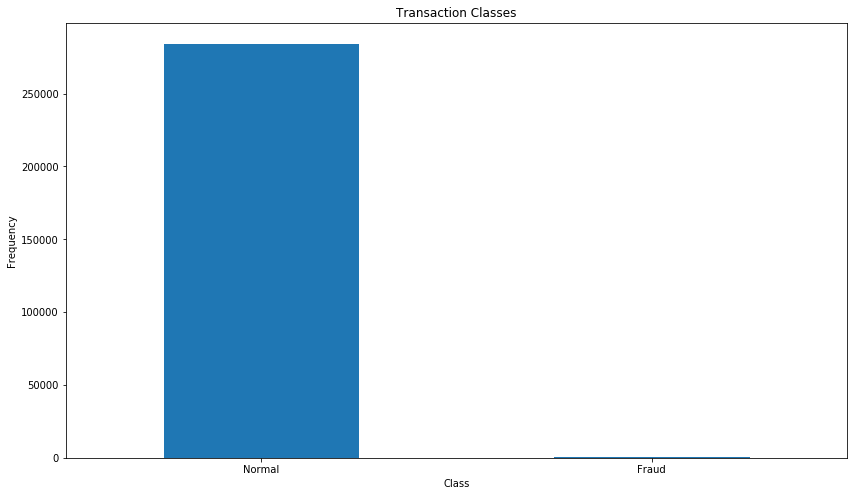

In [40]:
num_classes = pd.value_counts(data['Class'], sort = True)

num_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Classes")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [41]:
fraud = data[data['Class']==1]
normal = data[data['Class']==0]

print(fraud.shape)
print(normal.shape)

(492, 31)
(284315, 31)


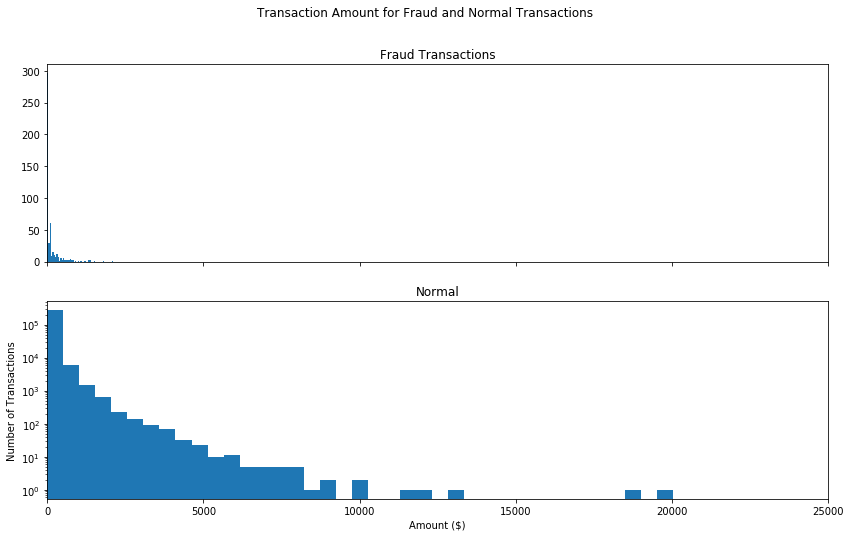

In [42]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Transaction Amount for Fraud and Normal Transactions')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud Transactions')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 25000))
plt.yscale('log')
plt.show()

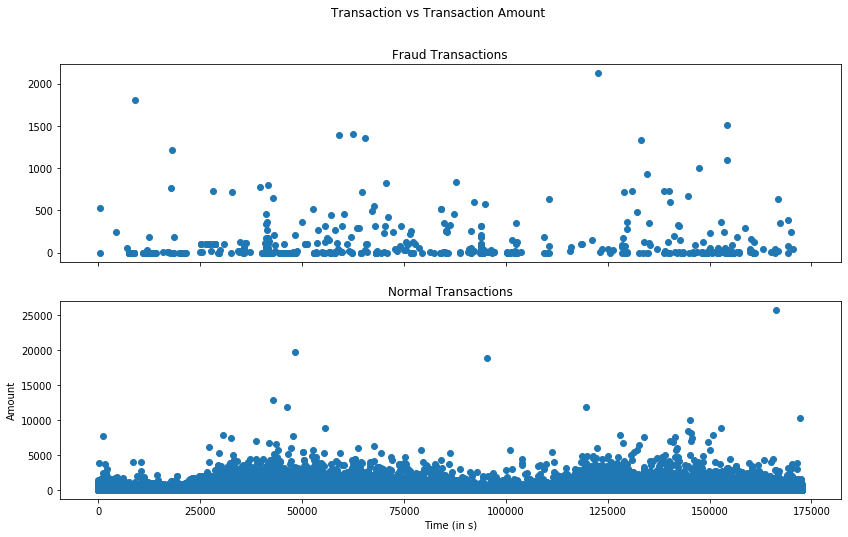

In [43]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Transaction vs Transaction Amount')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud Transactions')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal Transactions')
plt.xlabel('Time (in s)')
plt.ylabel('Amount')
plt.show()

In [44]:
data1= data.sample(frac = 0.1,random_state=1)

data1.shape

(28481, 31)

In [45]:
Fraud = data1[data1['Class']==1]

Valid = data1[data1['Class']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [46]:
print(f"Fraud Cases : {len(Fraud)}")
print(f"Valid Cases : {len(Valid)}")
print(outlier_fraction)

Fraud Cases : 49
Valid Cases : 28432
0.0017234102419808666


In [47]:
columns = data1.columns.tolist()
columns = [c for c in columns if c not in ["Class"]]
target = "Class"
state = np.random.RandomState(42)
X = data1[columns]
Y = data1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
print(X.shape)
print(Y.shape)

(28481, 30)
(28481,)


In [48]:
#Isolation Forest

In [49]:
classifiers = {"Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski',p=2, metric_params=None, contamination=outlier_fraction)}

In [50]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Isolation Forest: 73
Accuracy Score :
0.9974368877497279
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.26      0.27      0.26        49

    accuracy                           1.00     28481
   macro avg       0.63      0.63      0.63     28481
weighted avg       1.00      1.00      1.00     28481

Local Outlier Factor: 97
Accuracy Score :
0.9965942207085425
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.02      0.02      0.02        49

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481

